In this notebook, we use a number of packages. You might need to install `tqdm` and `opencv-python` (this is not necessary on Colab)

In [1]:
import os
import tensorflow as tf
import IPython
import functools
import tarfile
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py
import cv2
# from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Flatten, Reshape, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Note that you don't need to run this notebook in Colab, because all models have been pre-trained. If you want to train a model from scratch, Colab (or another way of training with GPU) is strongly advised.

Change the flag below as needed in case you are going for Colab:

In [2]:
google = False
if google:
    path = 'gdrive/MyDrive/'
    from google.colab import drive
    drive.mount('/content/gdrive')
else:
    path = 'Pre-trained/'

# 1. Interpreting what CNNs learn

In the first part of the notebook, we try to understand better what convolutional neural networks learn, by displaying their activations. This part of the notebook is based on the Chollet, 2021, Deep Learning with Python, Second Edition.

We start by loading a pre-trained model `"pretrained_cnn.keras"`. Make sure to upload this to Google Drive if using Colab or have it in the same folder as the notebook otherwise.

PS: don't worry about the Warnings.

In [4]:
model = tf.keras.models.load_model(path + "pretrained_cnn.keras")
model.summary()

2023-04-11 16:17:19.580617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TypeError: weight_decay is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.

Note that the model we are using has been trained to differentiate images of cats and dogs. We will use a single cat image as an example throughout. See below:

80329/80329 [==============================] - 2s 20us/step


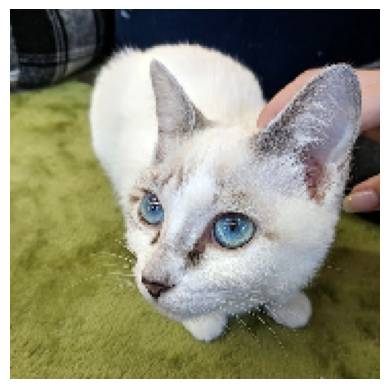

In [13]:
img_path = tf.keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = tf.keras.utils.load_img(
        img_path, target_size=target_size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

## 1.1 Visualizing intermediate activations

We start by creating a new model that takes the image (or images), and gives the output of each of the layers of the network (as a list):


In [14]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (Conv2D, MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

NameError: name 'model' is not defined

Take a look at the activation of the first layer, in particular the shape. Does this make sense to you?

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

We will now take a look at the first channel within the first layer. You can play around with the variable `channel` to change which channel is being displayed.

In [ ]:
channel = 0
plt.matshow(first_layer_activation[0, :, :, 0], cmap="viridis")

It seems like the channel has trained to detect vertical edges that go from dark to bright.

We will now plot all channels within all layers of the network:

In [ ]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

**Discussion**: What do you notice?

## 1.2 Visualizing convolutional filters

We can also take a look at the patterns that filters are supposed to respond to. Basically, we create an image that leads to the maximum response (or activation) from that filter. Don't worry too much about the implementation details. The key idea to remember is that we start from a randomly generated image and change it so as to maximize the filter activation. For this we use gradient ascent (rather than descent).

In [ ]:
img_width = 180
img_height = 180

def compute_loss(image, layer_index, filter_index):
    activation = activation_model(image)[layer_index]
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(image, layer_index, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, layer_index, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image
    
def generate_filter_pattern(layer_index, filter_index):
    iterations = 50
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, layer_index, filter_index, learning_rate)
    return image[0].numpy()

def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

You can now take a look at the pattern that maximizes the response of different filters (or channels) at different layers. Note that the method is far from perfect, so many cases will seem to respond to white noise the most. Moreover, the deeper we go the more there we will come across channels that are not relevant to the classification problem.

Some examples to try out:
- Layer 0, Filters 1 and 2
- Layer 2, Filters 2 and 10
- Layer 6, Filter 120
- Layer 8, Filter 3

In [ ]:
layer_index = 2
filter_index = 2
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(layer_index,filter_index)))

**Discussion**: What do you notice?

## 1.3 Heatmaps of class activation

Probably the most applied technique is to visualize a heatmap of class activation. That is, a heatmap showing which part of an image leads to choosing a specific class as our prediction.

The idea is that we take the final convolutional layer and weighing its channels (or filters) based on how strongly they affect the output (prediction). To measure this, we use the gradient of the prediction with respect to each channel. Again, don't worry too much about the implementation details here.

In [ ]:
last_conv_layer = model.get_layer(layer_names[-1])
last_conv_layer_model = tf.keras.Model(inputs=model.input, outputs=last_conv_layer.output)

classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer in model.layers[-3:]:
    x = layer(x)
classifier_model = tf.keras.Model(classifier_input,x)

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_tensor)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    
grads = tape.gradient(top_class_channel, last_conv_layer_output)

We can now display the heatmap. The brighter colors indicate the part of the final convolutional layer that are more important with respect to deciding the class of the image (here, whether this is a cat rather than a dog)

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output_np = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output_np[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output_np, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

So far, so good. But what does this actually correspond to? We can take a look by superimposing the heatmap on the original image:

In [ ]:
heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_tensor.shape[1], img_tensor.shape[2]))
jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.8 + img_tensor[0,:,:,:]
superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

plt.imshow(superimposed_img)

**Discussion**: What do you notice?

# 2. Detecting bias

Deploying fair, unbiased AI systems is critical to their long-term acceptance. Consider the task of facial detection: given an image, is it an image of a face?  This seemingly simple, but extremely important, task is subject to significant amounts of algorithmic bias.

In this part of the notebook, we'll investigate [one recently published approach](https://dl.acm.org/doi/pdf/10.1145/3306618.3314243) to addressing algorithmic bias. This is based in parts on [© MIT 6.S191: Introduction to Deep Learning](http://introtodeeplearning.com).

## 2.1 Data

For training our facial detection model, we will use two image datasets: one with "positive" examples (that is, faces) and one with "negative" examples (that is, images with other objects in them). We use:

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale database (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). Many (more than 1 mio.) images across many different categories. We take negative examples from a variety of non-human categories. 

Let's begin by importing approximately 50,000 images from each of these datasets (some pre-processing has already been done to make things more useable).

In [ ]:
# Get the training data: both images from CelebA and ImageNet are combined in this '.h5' file
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/9bh4cetqj8ldhys/train_face.h5?dl=1')
data = h5py.File(path_to_training_data, 'r')

images = data['images'][:]
labels = data['labels'][:].astype(np.float32)

The training set contains quite a few images:

In [ ]:
images.shape[0]

Play around with displaying images to get a sense of what the training data actually looks like:

In [ ]:
idx_face = 10
idx_not_face = 15

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(images[np.where(labels==1)[0]][idx_face], cv2.COLOR_BGR2RGB))
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(images[np.where(labels==0)[0]][idx_not_face], cv2.COLOR_BGR2RGB))
plt.title("Not Face"); plt.grid(False)

We will split off a number of images for validation and testing. Keep in mind that we have more than 100,000 images, so even a small percentage should be fine for this task. For example, we choose 3,000 validation and 3,000 test images.

In [ ]:
X_train, X_other, y_train, y_other = train_test_split(images, labels, test_size = 6000, random_state=492)
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size = 3000, random_state=271)

del images # Since the images are quite large, we will save some memory space by deleting the original variable.

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Because memory is constrained, we cannot normalize the images (that would mean we need a float array, which takes up a lot more space than an int array). Instead, we will use the `ImageDataGenerator` to rescale the images on the go. The downside is that this means training takes a lot longer. The upside is that we save on memory.

Note that we are not adding any data augmentation here, because we have quite a large dataset already.

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

## 2.2 CNN for face detection 

First, we'll define and train a CNN on the face detection task, and evaluate its accuracy. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction. 

### Define and train the CNN model

We'll define our CNN model, and then train on the combined CelebA and ImageNet dataset.

Let's start with the model definition (we keep the baseline number of filters as a variable. This would be a good starting point to fine-tune the model later):

In [ ]:
n_filters = 12

standard_classifier = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu', input_shape = [64,64,3]),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid'),
    ])

standard_classifier.compile(loss="binary_crossentropy",
                              optimizer=tf.keras.optimizers.Adam(5e-4),
                              metrics=["accuracy"])

standard_classifier.summary()

Now that we have defined our model, we can either train it from scratch or load existing weights.

**Option 1: Training the model from scratch**

Option 1 is to train our standard model from scratch:

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(path+"standard_classifier_best_model", monitor = 'val_accuracy', mode='max', save_weights_only=True,save_best_only=True)

log = standard_classifier.fit(datagen.flow(X_train, y_train, batch_size = 32),
                                epochs=32,
                                validation_data = datagen.flow(X_valid, y_valid),
                                callbacks = [model_checkpoint_callback])

In [ ]:
standard_classifier.load_weights(path+"standard_classifier_best_model")
tf.keras.backend.clear_session()

**Option 2: Loading the pre-trained weights**

Instead of training the model from scratch, we can also use pre-trained model weights (assuming you haven't changed the model definition)

In [ ]:
standard_classifier.load_weights(path+"standard_classifier_best_model")

### Evaluate performance of the standard CNN

First, we evaluate the classification performance of our CelebA/ImageNet-trained standard CNN on the test dataset.

In [ ]:
standard_classifier.evaluate(datagen.flow(X_test, y_test))

This seems quite good, right? However, there is a catch, which we focus on next.

### Diagnosing algorithmic bias

CNNs like the one we just built are pervasive as the standard solution for facial detection pipelines implemented throughout society. Despite their pervasiveness, these models - including those implemented by top tech companies - suffer from tremendous amounts of algorithmic bias. The seminal work of [Buolamwini and Gebru](https://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf) provided an approach and benchmark dataset to evaluate facial analysis algorithms, revealing startling accuracy discrepancies across skin tone and gender demographics.

In order to solve this problem and build fair and robust models, the first step is to determine the extend of the problem.

**Discussion**: How would you anlayze whether there are biases present in our facial recognition algorithm?

**Naive approach**

A naive approach - and one that is being adopted by many companies and organizations - would be to annotate different subclasses (i.e., light-skinned females, males with hats, etc.) within the training data, and then evaluate classifier performance with respect to these groups.



We try this out by adding an additional test set with images that have not been seen by our model so far. In particular, this test set has equal representation of two protected features: skin tone and gender. To label images based on skin tone as "Darker" or "Lighter", the [Fitzpatrick Scale](https://en.wikipedia.org/wiki/Fitzpatrick_scale) skin type classification system is employed.
Overall, we have four categories: dark-skinned female, dark-skinned male, light-skinned female, and light-skinned male. 

Let's load in the additional data and take a look at some sample faces:

In [ ]:
path_to_face_data =  tf.keras.utils.get_file('faces.tar.gz', 'https://www.dropbox.com/s/dwlujnhe9dkl4nj/faces.tar.gz?dl=1')
file = tarfile.open(path_to_face_data)
file.extractall(os.path.abspath(os.path.join(path_to_face_data, os.pardir)))
file.close()

In [ ]:
test_faces = {
    "DF": [],
    "DM": [],
    "LF": [],
    "LM": []
}
for key in test_faces.keys():
    path2 = os.path.abspath(os.path.join(path_to_face_data, os.pardir, 'faces/'+key))
    for img in [f for f in os.listdir(path2) if not f.startswith('.')]:
        try:
            img_arr = cv2.imread(os.path.join(path2, img))
            img_arr = cv2.resize(img_arr, (64,64)) / 255
            test_faces[key].append(img_arr)
        except Exception as e:
            print(e)

In [ ]:
keys = ["Dark Female", "Dark Male","Light Female", "Light Male"]
for group, key in zip(test_faces,keys): 
    plt.figure(figsize=(20,20))
    plt.imshow(np.hstack(np.array(test_faces[group]))[:,:,::-1])
    plt.title(key, fontsize=15)

Now, let's evaluate the probability of each of these face demographics being classified as a face using the standard CNN classifier we've just trained. In particular, we plot, for each demographic, the probability the classifier gives that the image is a face:

In [ ]:
xx = range(len(keys))
yy = [np.mean(standard_classifier.predict(np.array(test_faces[group]))) for group in test_faces]
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,np.min(yy)-np.ptp(yy)/2.), np.max(yy)+np.ptp(yy)/2.)
plt.title("Standard classifier predictions");

**Discussion**: Take a look at the accuracies for this first model and the predictions across these four groups.
1. What do you observe?
1. Would you consider this model biased or unbiased?
1. What are some reasons why the model may be biased?


**Automatically uncovering hidden biases**

Imbalances in the training data can result in unwanted algorithmic bias. For example, the majority of faces in CelebA (our training set) are those of light-skinned females. As a result, a classifier trained on CelebA will be better suited at recognizing and classifying faces with features similar to these, and will thus be biased.

Our naive approach to uncovering such biases has two major disadvantages. First, it requires annotating massive amounts of data, which is not scalable. Second, it requires that we know what potential biases (e.g., race, gender, pose, occlusion, hats, glasses, etc.) to look for in the data. As a result, manual annotation may not capture all the different sources of bias and uncertainty that may exist.

What if we actually *learned* the distribution of data features in an unbiased, unsupervised manner, without the need for any annotation? What could such an approach tell us about hidden biases that may exist in the data, or regions of the data in which the model is less confident in its predictions?

## 2.3 Semi-supervised variational autoencoder (SS-VAE)

We will use the ideas behind the VAE architecture to build a model to automatically uncovers (potentially) unknown biases present within the training data, while simultaneously learning the facial detection task. In particular, our VAE will have a supervised component in order to both output a classification decision for the facial detection task and analyze where the biases in our model may be resulting from. While previous works like that of Buolamwini and Gebru have focused on skin tone and gender as two categories where facial detection models may be experiencing bias, there may be other unlabeled features that also are biased, resulting in poorer classification performance. We will build our SS-VAE to learn these underlying latent features.

### Define the SS-VAE architecture

We start by defining SS-VAE architecture. To build the SS-VAE, we will use the standard CNN classifier from above as our encoder (with slightly modified outputs), and then define a decoder network. We will use a latent space ("encoding") with 32 latent variables.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers ("transpose convolutions"), and output a reconstruction of the original input image.

In [ ]:
n_filters = 12

def create_encoder(n_outputs):
    model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu', input_shape = [64,64,3]),
        BatchNormalization(),

        Conv2D(filters=2*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
        BatchNormalization(),

        Conv2D(filters=4*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
        BatchNormalization(),

        Conv2D(filters=6*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
        BatchNormalization(),

        Flatten(),
        Dense(512, activation='relu'),
        Dense(n_outputs)
    ])
    return model

def create_decoder():
    model = tf.keras.Sequential([
        Dense(4*4*6*n_filters, activation='relu'),
        Reshape(target_shape=(4,4,6*n_filters)),
        
        Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
        Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2, padding='same', activation='relu'),
        Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2, padding='same', activation='relu'),
        Conv2DTranspose(filters=3, kernel_size=5,  strides=2, padding='same', activation='relu')
    ])
    return model

Now, we will put the encoder and decoder together to define the SS-VAE. This is a bit more complex than building an autoencoder, and we need a more customized model, which we can build by subclassing the `tf.keras.Model` class. We also need a separate "sampling" function that allows to draw samples from the "latent space".

In [ ]:
def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))

    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
    return z

In [ ]:
class SS_VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(SS_VAE, self).__init__()
        self.latent_dim = latent_dim

        # Define the number of outputs for the encoder. Recall that we have 
        # `latent_dim` latent variables, as well as a supervised output for the 
        # classification.
        num_encoder_dims = 2*self.latent_dim + 1

        self.encoder = create_encoder(num_encoder_dims)
        self.decoder = create_decoder()

    # function to feed images into encoder, encode the latent space, and output
    # classification probability 
    def encode(self, x):
        # encoder output
        encoder_output = self.encoder(x)

        # classification prediction
        y_logit = tf.expand_dims(encoder_output[:, 0], -1)
        # latent variable distribution parameters
        z_mean = encoder_output[:, 1:self.latent_dim+1] 
        z_logsigma = encoder_output[:, self.latent_dim+1:]

        return y_logit, z_mean, z_logsigma

    # Decode the latent space and output reconstruction
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    # The call function will be used to pass inputs x through the core VAE
    def call(self, x): 
        # Encode input to a prediction and latent space
        y_logit, z_mean, z_logsigma = self.encode(x)
        z = sampling(z_mean, z_logsigma)
        recon = self.decode(z)
        return y_logit, z_mean, z_logsigma, recon

    # Predict face or not face logit for given input x
    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit

Next, we define `get_batch`, which provides a way to select a new batch of images from the training set (both faces and non-faces) with a given batch size (recall that in each iteration of training, we don't use all our training data, but a "mini-batch" subset of the training data). We choose non-faces uniformly at random. For faces, we also select randomly, but we use the probabilities computed with `get_training_sample_probabilities` to better represent all latent features.

In [ ]:
train_inds = np.random.permutation(np.arange(X_train.shape[0]))
val_inds = np.random.permutation(np.arange(X_valid.shape[0]))
pos_train_inds = train_inds[ y_train[train_inds, 0] == 1.0 ]
neg_train_inds = train_inds[ y_train[train_inds, 0] != 1.0 ]
pos_val_inds = val_inds[ y_valid[val_inds, 0] == 1.0 ]
neg_val_inds = val_inds[ y_valid[val_inds, 0] != 1.0 ]

def get_batch(n, p_pos=None, p_neg=None, only_faces=False, validation = False):
    if validation:
        X = X_valid
        y = y_valid
        pos_inds = pos_val_inds
        neg_inds = neg_val_inds
    else:
        X = X_train
        y = y_train
        pos_inds = pos_train_inds
        neg_inds = neg_train_inds

    if only_faces:
        selected_inds = np.random.choice(pos_inds, size=n, replace=False, p=p_pos)
    else:
        selected_pos_inds = np.random.choice(pos_inds, size=n//2, replace=False, p=p_pos)
        selected_neg_inds = np.random.choice(neg_inds, size=n//2, replace=False, p=p_neg)
        selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))

    sorted_inds = np.sort(selected_inds)
    train_img = (X[selected_inds,:,:,:]/255.).astype(np.float32)
    train_label = y[selected_inds,:]
    return (train_img, train_label)

Finally, we need to compute an appropriate loss function in each iteration. We combine three types of losses:
- reconstruction loss: you should be familiar with this from autoencoders - how good does our output recreate our input? Note that this is only relevant when the image is of a face!
- latent loss: this is specific to variational autoencoders and helps to bring the distributions learned by the encoder into the "right shape" (essentially, we want to have standard normal distributions)
- classification loss: this is the loss that is purely based on the quality of our classification, i.e., the usual binary cross-entropy

In [ ]:
def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma, kl_weight=0.0005):

    latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.abs(x-x_pred), axis=(1,2,3))
    vae_loss = kl_weight * latent_loss + reconstruction_loss

    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
    face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

    total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
    )

    return total_loss, classification_loss, vae_loss

### Training the SS-VAE

As before, we can either train the model or load a pre-trained model.

**Option 1: Training the model from scratch**

The training process is a bit more manual here than what we have seen before. This is because we are defining many aspects of the process ourselves, instead of using standard modules. Don't worry too much about the details - we are still using forward- and back-propagation and employing the `Adam` algorithm to run the optimization.

In [ ]:
# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 32
num_epochs = 12

# instantiate a new SS-VAE model and optimizer
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def ss_vae_train_step(x, y):

    with tf.GradientTape() as tape:
        # Feed input x into ss_vae. Note that this is using the SS_VAE call function!
        y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
        # call the SS_VAE loss function to compute the loss
        loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
  
    # use the GradientTape.gradient method to compute the gradients.
    grads = tape.gradient(loss, ss_vae.trainable_variables)
  
    # apply gradients to variables
    optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
    return loss

# get training faces
all_faces = X_train[pos_train_inds]

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
min_val_loss = np.inf
for i in range(num_epochs):

    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i+1, num_epochs))

    # get a batch of training data and compute the training step
    for j in tqdm(range(train_inds.shape[0] // batch_size)):
        # load a batch of data
        (x, y) = get_batch(batch_size)
        # loss optimization
        loss = ss_vae_train_step(x, y)
        
        # Plot the progress every 500 steps
        if j % 500 == 0:
            plt.figure(figsize=(2,1))
            plt.subplot(1, 2, 1)

            idx = np.where(y==1)[0][0]
            plt.imshow(cv2.cvtColor(x[idx],cv2.COLOR_BGR2RGB))
            plt.grid(False)

            plt.subplot(1, 2, 2)
            _, _, _, recon = ss_vae(x)
            recon = np.clip(recon, 0, 1)
            plt.imshow(cv2.cvtColor(recon[idx],cv2.COLOR_BGR2RGB))
            plt.grid(False)

            plt.show()
    # Save weights if validation loss has decreased
    (x, y) = get_batch(min(batch_size*4,y_valid.shape[0]), validation=True)
    y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
    loss, _, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    if loss < min_val_loss:
        min_val_loss = loss
        ss_vae.save_weights(path+"ss_vae_best_model")

In [ ]:
ss_vae.load_weights(path+"ss_vae_best_model")

**Option 2: Loading the pre-trained weights**

Instead of training the model from scratch, we can also use pre-trained model weights

In [ ]:
latent_dim = 32
ss_vae = SS_VAE(latent_dim)
ss_vae.load_weights(path+"ss_vae_best_model")

If you didn't go through the training process, you might not be clear on what the SS-VAE has learned. Take a look below for an example:

In [ ]:
(x, y) = get_batch(1, only_faces=True, validation=True)
plt.figure(figsize=(2,1))
plt.subplot(1, 2, 1)

plt.imshow(cv2.cvtColor(x[0],cv2.COLOR_BGR2RGB)) # This will show the input image
plt.grid(False)

plt.subplot(1, 2, 2)
logit, _, _, recon = ss_vae(x)
recon = np.clip(recon, 0, 1)
plt.imshow(cv2.cvtColor(recon[0],cv2.COLOR_BGR2RGB)) # This will show the decoded version of the encoded input image
plt.grid(False)

print("The SS-VAE predicted that this image is a face with probability",round(1/(1+np.exp(-logit[0][0])),4))

## 2.4 Using the SS-VAE to uncover and diagnose biases

We are now ready to use the SS-VAE to uncover and diagnose hidden biases that exist within the dataset.

Recall that our goal was to learn the underlying *latent distribution* of features in the training dataset, in order to uncover potential feature representation disparities that exist within the data. Additionally, training the SS-VAE required both a VAE reconstruction loss as well as a supervised classification loss. The VAE reconstruction loss direclty reflects how well the model is able to handle particular input data - the higher the reconstruction loss, the harder that particular example is for the model to learn.

We consider both these aspects to understand sources of uncertainty and bias within the model.

### Linking model performance to uncertainty and bias

We begin by considering the examples in the dataset with the highest loss. What can you tell about which features seemed harder to learn for the VAE? What might this tell us about where the model struggles, and what predictions it may be more biased or uncertain about?

**Discuss**: Using the code below, try to answer the following questions:
1. What, if any, trends do you observe comparing the samples with the highest and lowest reconstruction loss?
1. Based on these observations, which features seemed harder to learn for the VAE?
1. How does reconstruction loss relate to uncertainty? What can you say about examples on which the model may be more or less uncertain?

In [ ]:
# Load a random sample of 5000 faces from our training dataset and compute the model performance on them
(x, y) = get_batch(5000, only_faces=True)
y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

# Sort the results by the vae loss scores
vae_loss = vae_loss.numpy()
ind = np.argsort(vae_loss, axis=None)

def create_grid_of_images(xs, size=(3,5)):
    grid = []
    counter = 0
    for i in range(size[0]):
        row = []
        for j in range(size[1]):
            row.append(xs[counter])
            counter += 1
        row = np.hstack(row)
        grid.append(row)
    grid = np.vstack(grid)
    return grid

# Plot the 15 samples with the highest and lowest reconstruction losses
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(cv2.cvtColor(create_grid_of_images(x[ind[:15]]),cv2.COLOR_BGR2RGB))
ax[0].set_title("Samples with the lowest reconstruction loss \n" + 
                f"Average recon loss: {np.mean(vae_loss[ind[:15]]):.2f}")

ax[1].imshow(cv2.cvtColor(create_grid_of_images(x[ind[-15:]]),cv2.COLOR_BGR2RGB))
ax[1].set_title("Samples with the highest reconstruction loss \n" + 
                f"Average recon loss: {np.mean(vae_loss[ind[-15:]]):.2f}");
     

### Uncovering hidden biases through learned latent features

As we've seen above, loss is a powerful way to visualize which samples in our dataset the model has had trouble learning - these examples are those that have high model uncertainty. However, this is not necessarily the same as bias!

How can we determine the relative frequencies and distributions of different latent features learned by the model? How may these metrics reveal underlying biases?

Let's investigate how well the SS-VAE actually learned the latent features of the faces. To do this, we will inspect individual latent features - holding all others constant - and look at the distribution of these features in the data and their corresponding examples. We can examine the shape and probability density of the learned latent features. Further we directly compare different values of individual latent variables to corresponding relative classification accuracies (marginalizing out the effects of the other latent variables).

**Discuss**: Using the code below, inspect the different latent variables and their corresponding frequency distributions. Try to answer the following questions:

1. Pick a few latent variables and describe what semantic meaning they reflect.
1. For the latent variables selected, what can you tell about which features are under- or over-represented in the data? What might this tell us about how the model is biased?
1. For the latent variables selected, how do these feature distribution differences affect classification performance? What, if any, general trends do you observe across the latent variables?

In [ ]:
idx_latent = 10 # Explore other latent variables by changing the index here
num_steps = 15

# Extract all latent samples from the desired dimension
latent_samples = z_mean[:, idx_latent]

# Compute their density and plot
density, latent_bins = np.histogram(latent_samples, num_steps, density=True)
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].bar(latent_bins[1:], density)
ax[0].set_ylabel("Data density")

# Visualize reconstructions as we walk across the latent space
latent_steps = np.linspace(np.min(latent_samples), np.max(latent_samples), num_steps)
baseline_latent = tf.reduce_mean(z_mean, 0, keepdims=True)

recons = []
for step in latent_steps: 
    # Adjust the latent vector according to our step
    latent = baseline_latent.numpy()
    latent[0, idx_latent] = step
    # Decode the reconstruction and store
    recons.append(ss_vae.decode(latent)[0])

# Visualize all of the reconstructions!
ax[1].imshow(cv2.cvtColor(create_grid_of_images(recons, (1, num_steps)),cv2.COLOR_BGR2RGB))
ax[1].set_xlabel("Latent step")
ax[1].set_ylabel("Visualization");

**Discuss**: Using the code below, what is your understanding of the bias of the facial detection classifier and where it comes from?

In [ ]:
# Loop through every latent dimension
avg_logit_per_bin = []
for idx_latent in range(latent_dim): 
    latent_samples = z_mean[:, idx_latent]
    start = np.percentile(latent_samples, 5)
    end = np.percentile(latent_samples, 95)
    latent_steps = np.linspace(start, end, num_steps)

    # Find which samples fall in which bin of the latent dimension
    which_latent_bin = np.digitize(latent_samples, latent_steps)

    # For each latent bin, compute the accuracy (average logit score)
    avg_logit = []
    for j in range(0, num_steps+1): 
        inds_in_bin = np.where(which_latent_bin == j)
        avg_logit.append(y_logit.numpy()[inds_in_bin].mean())

    avg_logit_per_bin.append(avg_logit)

# Average the results across all latent dimensions and all samples
accuracy_per_latent = np.mean(avg_logit_per_bin, 0)
accuracy_per_latent = (accuracy_per_latent - accuracy_per_latent.min()) / np.ptp(accuracy_per_latent)

# Plot the results
plt.plot(np.linspace(np.min(z_mean), np.max(z_mean), num_steps+1), accuracy_per_latent,'-o')
plt.xlabel("Latent step")
plt.ylabel("Relative accuracy")
     

## Appendix: more details about the SS-VAE

### Variational autoencoder (VAE) for learning latent structure (*not* semi-supervised yet)

Consider first the structure of a variational autoencoder (VAE):

![The concept of a VAE](https://i.ibb.co/3s4S6Gc/vae.jpg)

As shown in the schematic, VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn. 

Let's formalize two key aspects of the VAE model and define relevant functions for each.

#### The VAE loss function

In practice, how can we train a VAE? In learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are learned parameters, and therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. What this means is that we'll have two terms in our VAE loss function:

1.  **Latent loss ($L_{KL}$)**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.
2.   **Reconstruction loss ($L_{x}{(x,\hat{x})}$)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstructed output.

The equation for the latent loss is provided by:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

The equation for the reconstruction loss is provided by:

$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

Thus for the VAE loss we have:

$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

where $c$ is a weighting coefficient used for regularization.

#### The VAE reparameterization process

VAEs use a "reparameterization  trick" for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample from the standard deviations and add back the mean to output this as our sampled latent vector. Formalizing this for a latent variable $z$ where we sample $\epsilon \sim N(0,(I))$ we have: 

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

where $\mu$ is the mean and $\Sigma$ is the covariance matrix. This is useful because it lets us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, *and* make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!

### Semi-supervised variational autoencoder (SS-VAE)

We use the general idea behind the VAE architecture to build a model, termed a semi-supervised variational autoencoder or SS-VAE, to uncover (potentially) unknown biases present within the training idea.

#### The SS-VAE model

We will develop a VAE that has a supervised component in order to both output a classification decision for the facial detection task and analyze where the biases in our model may be resulting from. While previous works like that of Buolamwini and Gebru have focused on skin tone and gender as two categories where facial detection models may be experiencing bias, there may be other unlabeled features that also are biased, resulting in poorer classification performance. We will build our semi-supervised VAE (SS-VAE) to learn these underlying latent features.

A general schematic of the SS-VAE architecture is shown here.

![SS-VAE](attachment:image.png)

Recall that we want to apply our SS-VAE to a *supervised classification* problem - the facial detection task. Importantly, note how the encoder portion in the SS-VAE architecture also outputs a single supervised variable, $z_o$, corresponding to the class prediction - face or not face. Usually, VAEs are not trained to output any supervised variables (such as a class prediction)! This is the key distinction between the SS-VAE and a traditional VAE. 

Keep in mind that we only want to learn the latent representation of *faces*, as that's what we're ultimately debiasing against, even though we are training a model on a binary classification problem. We'll need to ensure that, **for faces**, our SS-VAE model both learns a representation of the unsupervised latent variables, captured by the distribution $q_\phi(z|x)$, **and** outputs a supervised class prediction $z_o$, but that, **for negative examples**, it only outputs a class prediction $z_o$.

#### Defining the SS-VAE loss function

This means we'll need to be a bit clever about the loss function for the SS-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered. 

For **face images**, our loss function will have two components:


1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem. 

In contrast, for images of **non-faces**, our loss function is solely the classification loss. 

We can write a single expression for the loss by defining an indicator variable $\mathcal{I}_f$which reflects which training data are images of faces ($\mathcal{I}_f(y) = 1$ ) and which are images of non-faces ($\mathcal{I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + \mathcal{I}_f(y)\Big[L_{VAE}\Big]$$